In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy.linalg import norm
np.random.seed(42)
import scipy.optimize
import sys
np.set_printoptions(threshold=sys.maxsize)
import seaborn as sns

In [2]:
#IMPORT DATA
xj=np.array([535, 749, 963, 1177, 1391, 1605, 1819, 2033, 2247, 2461, 2675, 2889]) # [m]
anomaly=np.array([-15.1, -23.9, -31.2, -36.9, -40.8, -42.8, -42.5, -40.7, -37.1, -31.5, -21.9, -12.9])*1e-5 # [m/sec^2]

In [3]:
#INITIALIZE

#Input for the space 
d_rho = -1733 # [kg m^−3]
alpha=3.42*1e3 # [m]
Grav = 6.67408e-11


#M=len(xj)
M=24
x=np.linspace(0,alpha,M)#+0.01
dx=alpha/M 



# Input section for the simpson 3/8 function
lower_limit = float(0)
upper_limit = float(alpha)
sub_interval = 3*int(10)     #this must stay a multiple of 3, thats how simpson's 3/8 works.

# Input for the pertrubation function
l = 50 # [m] pertrubation step
n_steps = 50000 #iterations

#Input for the a posteriori
const=1

#Input for the MarkovChain function
burnin = 2000 #int(n_steps/10)

NEXT in order to calculate the starting model m0, we are going to fit given data with a parabola

In [4]:
# define fitting function
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

In [5]:
#fit the data with the function
fit_params, pcov = scipy.optimize.curve_fit(parabola, xj, anomaly)

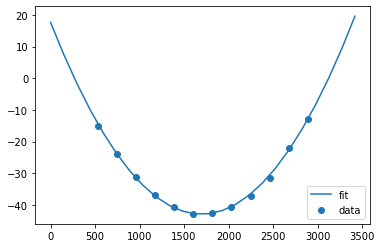

In [6]:
#Plot data and fitted function
y_fit = parabola(x, *fit_params)
plt.plot(x, y_fit*1e5, label='fit')
plt.scatter(xj,anomaly*1e5,label='data')
plt.legend(loc='lower right')  
plt.show()

In [7]:
# #Calculate dg for x points(sensors) from the function fitted to the observed data
# def dg(x):
#     dg=parabola(x,*fit_params)
#     return dg

In [8]:
dg1 = anomaly #dg(xj) #or =

In [9]:
# x2=np.array([ 749, 1177, 1605,  2033, 2461, 2889]) # [m]
# #x2=np.linspace(xj[0],xj[11],100)
# dg2=dg(x2)
# dg2

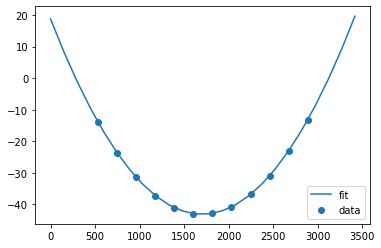

In [10]:
x2=np.array([ 749, 1177, 1605,  2033, 2461, 2889]) # [m]
anomaly2=np.array([ -23.9,  -36.9,  -42.8,  -40.7,  -31.5,  -12.9])*1e-5 # [m/sec^2]

#fit the data with the function
fit_params2, pcov2 = scipy.optimize.curve_fit(parabola, x2, anomaly2)

#Calculate dg for x points(sensors) from the function fitted to the observed data
def dg(x):
    dg=parabola(x,*fit_params2)
    return dg

dg2=dg(xj)
dg2

x2=xj

#Plot data and fitted function
y_fit2 = parabola(x, *fit_params2)
plt.plot(x, y_fit2*1e5, label='fit')
plt.scatter(xj,dg2*1e5,label='data')
plt.legend(loc='lower right')  
plt.show()

In [11]:
#USING the parabola calculated dg to find an approximation of m0 model
def m0(dg):
    m0=dg/(2*np.pi*Grav*d_rho)
    return m0

In [12]:
m01=m0(dg1)

m02=m0(dg2)

In [13]:
m01=anomaly/(2*np.pi*Grav*d_rho)
m01

array([207.7816105 , 328.87288019, 429.32359255, 507.75771042,
       561.42315949, 588.9439026 , 584.81579114, 560.04712234,
       510.50978473, 433.45170402, 301.35213708, 177.50879307])

In [14]:
# Define function to integrate
def func1(x,xj,m):
    return np.log( ( (x-xj)**2 + m**2 ) / (x-xj)**2  )

In [15]:
# Implementing Simpson's 3/8
def simpson38(f,m,xj,x0,xn,n):
    # calculating step size
    h = (xn - x0) / n

    # Finding sum 
    integration = f(x0,xj,m) + f(xn,xj,m)

    for i in range(1,n):
        k = x0 + i*h
                
        if i%2 == 0:
            integration = integration + 2 * f(k,xj,m)
        else:
            integration = integration + 3 * f(k,xj,m)

    # Finding final integration value
    integration = integration * 3 * h / 8
            
    return integration

In [16]:
# calculates d_est
def find_d_est(m,xj):
    # Call trapezoidal() method and get result
    integration= simpson38(func1,m,xj,lower_limit, upper_limit, sub_interval)
    d_est= Grav*d_rho*integration
    return d_est

In [17]:
#FINDING STARTING model and Δg
d_est01=np.zeros(len(xj))
d_est01=find_d_est(m01,xj+.01)

d_est02=np.zeros(len(x2))
d_est02=find_d_est(m02,x2+.01)

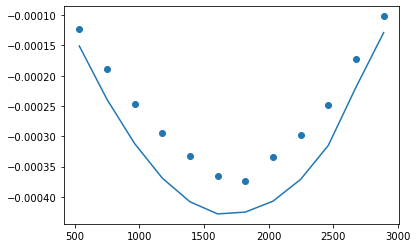

In [18]:
#plotting the starting model next to the given one
plt.plot(xj,dg1)
plt.scatter(xj,d_est01)   #Δg
plt.show()

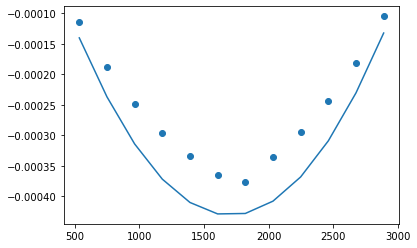

In [19]:
#plotting the starting model next to the given one
plt.plot(x2,dg2)
plt.scatter(x2,d_est02)   #Δg
plt.show()

In [20]:
def likelihood(dg,d_est):
#     Cd=((1.2*1e-5)**2)*np.eye(len(dg)) # [m/sec^2] data(noise) covariance matrix
#     #Cd=np.sqrt(1.2)*np.eye(len(dg))*1e-5 # [m/sec^2] data(noise) covariance matrix

#     L=np.exp(-(dg-d_est)@np.linalg.inv(Cd)@(dg-d_est)/2)
    L=np.exp(-.05*np.linalg.norm(dg-d_est)**2/(1.2*1e-5)**2)
    return L

In [21]:
def ppd(new_m,m0): #a priori probability density
#     Cm=((1200)**2)*np.eye(len(new_m)) # [m] a priori variances
#     p=np.exp(-(new_m-m0)@np.linalg.inv(Cm)@(new_m-m0)/2) 
#     #p=np.exp(-(new_m-m0)@np.linalg.inv(Cm)@(new_m-m0)/2)    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#     #print((new_m-m0))
    p=np.exp(-0.5*np.linalg.norm(new_m-m0)/(300**2))
    return p

In [22]:
def loglike(dg,d_est):
    """
    Computes the misfit of a given m-vector
    """
    Cd=((1.2*1e-5)**2)*np.eye(len(dg)) # [m/sec^2] data(noise) covariance matrix
    S = norm( (dg-d_est)@np.linalg.inv(Cd)@(dg-d_est)/2)

    return S

In [23]:
def m_perturb(m,l):
    """
    Perturbes m-vector within allowed limits
    """
    M=int(len(m))
    test = 1
    while test!=0:
        Model =np.copy(m)
        pert= np.random.uniform(-l,l)
        i = np.random.randint(0,M)
        Model[i] += pert 
        #print(Model)
        test = ( any(Model> 2000) + any(Model < 0))          #CHANGE THESE was <0 or-2000
    return Model

In [24]:
def accept(S_pert,S_k):
    """
    Computes acceptance chance for a pertubation and returns accept or reject
    """
    #S_pert=Like*prior
    # counter = 0
    #P=S_pert*S_k
    P = np.exp( -( -np.log(S_pert) - ( -np.log(S_k )  )  )) #this equals S_per/S_k
    #P = np.exp( (S_pert  - S_k   )) #this equals S_per/S_k

    #print(P)
    if P>=np.random.uniform(0,1):
        choice = True
    else:
        choice = False
    return choice

In [25]:
def MarkovChain(x,dg,m0,d_est):
    m = np.zeros((len(m0),n_steps+1))
    S_array = np.zeros(n_steps+1)
    L_array = np.zeros(n_steps+1)
    p_array = np.zeros(n_steps+1)
    sigma_array = np.zeros(n_steps+1)
    # Staring point for the Markov chain
    m[:,0] = m0
    S_k = loglike(dg,d_est)
    #print(loglike(d_est))
    L_k = likelihood(dg,d_est)
    p_k = ppd(m[:,0],m0)
    sigma_k=p_k*L_k

    S_array[0] = np.copy(S_k)
    L_array[0] = np.copy(L_k)
    p_array[0] = np.copy(p_k)
    sigma_array[0] = np.copy(sigma_k)
    #%% big loop - the Markov chain

    accepted = 0
    rejected = 0

    for i in range(n_steps):
        m_candidate = m_perturb(m[:,i],l)
        #print(i)
        #print("m_candidate",m_candidate)
        d_est=find_d_est(m_candidate,x+.0001)
        S_pert = loglike(dg,d_est)
        L_pert = likelihood(dg,d_est)
        p_pert = ppd(m_candidate,m0)
        sigma_pert = posterior_distr(L_pert,p_pert)
        #print("S_pert",S_pert)
        test = accept(sigma_pert,sigma_k)
        #test = accept(L_pert,L_k,p_pert,p_k)
        #test = accept(L_pert,L_k)

        if test==True:
            m[:,i+1] = np.copy(m_candidate)
            S_k = np.copy(S_pert)
            L_k = np.copy(L_pert)
            p_k = np.copy(p_pert)
            sigma_k = np.copy(sigma_pert)

            S_array[i+1] = np.copy(S_k)
            L_array[i+1] = np.copy(L_k)
            p_array[i+1] = np.copy(p_k)
            sigma_array[i+1] = np.copy(sigma_k)
            #print(S_array[i+1])
            accepted += 1
        else:
            m[:,i+1] = np.copy(m[:,i])
            S_array[i+1] = np.copy(S_k)
            L_array[i+1] = np.copy(L_k)
            p_array[i+1] = np.copy(p_k)
            sigma_array[i+1] = np.copy(sigma_k)
            rejected += 1

        if (i%10000)==0:
            print(f'{i} iterations, {accepted} accepted')
            #print(L_pert,L_k,p_pert,p_k)

    print(f'Acceptance rate = {accepted/i*100:.1f}')
    return(S_array,L_array,p_array,sigma_array,m)

In [26]:
#Calculate the a posteriori distribution
def posterior_distr(L,p):
    sigma=const*p*L
    return sigma

In [27]:
S_array,L_array,p_array,sigma_array,m=MarkovChain(xj,dg1,m01,d_est01)

S_array2,L_array2,p_array2,sigma_array2,m2=MarkovChain(x2,dg2,m02,d_est02)

0 iterations, 0 accepted
10000 iterations, 8513 accepted
20000 iterations, 17162 accepted
30000 iterations, 25856 accepted
40000 iterations, 34512 accepted
Acceptance rate = 86.4
0 iterations, 1 accepted
10000 iterations, 8573 accepted
20000 iterations, 17126 accepted
30000 iterations, 25674 accepted
40000 iterations, 34287 accepted
Acceptance rate = 85.8


In [28]:
#sigma_array,m

In [29]:
#Plot log_likelihood of the accepted pertrubated models, and the burn in
def plot_loglike(S_array):
    like_array = S_array

    lin = np.linspace(0,n_steps,n_steps+1)
    fig,ax = plt.subplots(tight_layout=True)
    ax.plot(lin,like_array)
    ax.plot([burnin,burnin],[np.min(like_array),np.max(like_array)],label='Burn-in point')
    ax.legend()
    ax.set_ylabel('misfit')
    ax.set_xlabel('accepted pertubations')
    ax.set_title('log(Likelihood) & burn-in')
    #ax.set_ylim(0,15)
    plt.show()

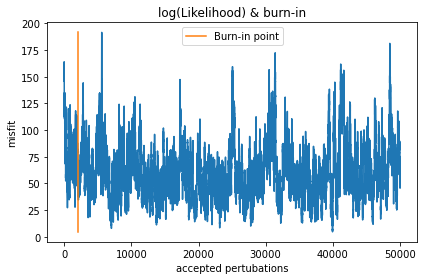

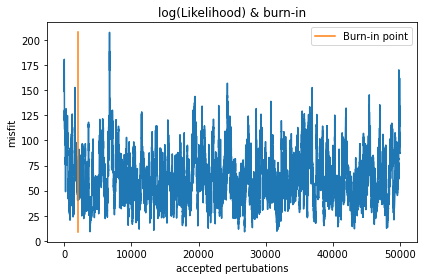

In [30]:
plot_loglike(S_array)


plot_loglike(S_array2)

In [31]:
#Plot likelihood of the accepted pertrubated models, and the burn in
def plot_likelihood(L_array):
    lin = np.linspace(0,n_steps,n_steps+1)
    fig,ax = plt.subplots(tight_layout=True)
    ax.plot(lin,L_array)
    ax.plot([burnin,burnin],[np.min(L_array),np.max(L_array)],label='Burn-in point')
    ax.legend()
    ax.set_ylabel('likelihood')
    ax.set_xlabel('accepted pertubations')
    ax.set_title('Likelihood & burn-in')
    # ax.set_xlim(150,n_steps)
    # ax.set_ylim(0.99975,1)
    plt.show()

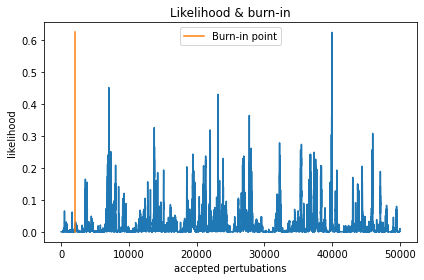

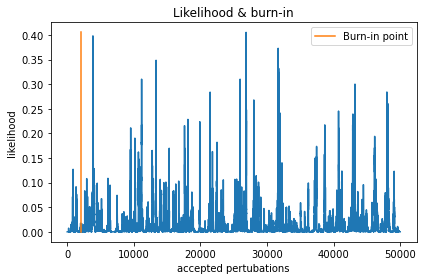

0.003223371923910381

In [32]:
plot_likelihood(L_array)

plot_likelihood(L_array2)
np.median(L_array)

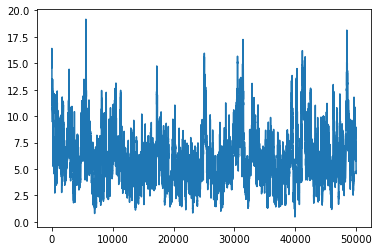

In [33]:
plt.plot(-np.log(sigma_array))


In [34]:
#Find and store (in new_model array) a large number of models distributed according to the a aposteriori distribution
# meaning less than 2 standard deviations away from the mean
def posterior_models(sigma):
    mu=np.mean(sigma)    #calculate the mean
    std=np.std(sigma)    #calculate the standard deviation

    index=np.where(abs(sigma-mu) <2*std)
    post_m=m[:,index[0]]
    return index, post_m

In [35]:
index, post_m=posterior_models(sigma_array)

index2, post_m2=posterior_models(sigma_array2)


In [36]:
#Plot the a posteriori distribution 
def plot_posterior_distr(sigma,index):
    fig2,ax2 = plt.subplots(3,1,tight_layout=True)

    ax2[0].hist(sigma[:],bins=100,histtype='step')
    ax2[0].set_ylabel('frequency')
    ax2[0].set_xlabel('a posteriori probability')
    ax2[0].set_title('a posteriori distribution with burn-in data')

    ax2[1].hist(sigma[burnin:],bins=100,histtype='step')
    ax2[1].set_ylabel('frequency')
    ax2[1].set_xlabel('a posteriori probability')
    ax2[1].set_title('a posteriori distribution without burn-in data')
    
    ax2[2].hist(sigma[index],bins=int(n_steps/100),histtype='step')
    ax2[2].set_ylabel('frequency')
    ax2[2].set_xlabel('a posteriori probability')
    ax2[2].set_title('a posteriori distribution for 2std data without burn-in data')
    plt.show()

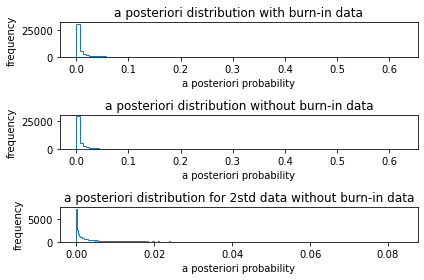

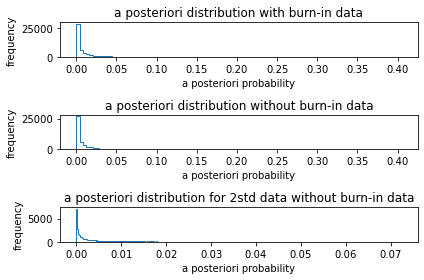

In [37]:
plot_posterior_distr(sigma_array,index)

plot_posterior_distr(sigma_array2,index2)

In [38]:
#same as above but in same plot
#Plot the a posteriori distribution 
def plot_posterior_distr2(sigma):
    fig3,ax3 = plt.subplots(tight_layout=True)
    ax3.hist(sigma[:],bins=int(n_steps/100),histtype='step',label='a posteriori distribution with burn-in data')
    ax3.hist(sigma[burnin:],bins=int(n_steps/100),histtype='step',label='a posteriori distribution without burn-in data')
    ax3.hist(sigma[index],bins=int(n_steps/100),histtype='step',label='a posteriori distribution for 2std data without burn-in data')
    ax3.set_ylabel('frequency')
    ax3.set_xlabel('a posteriori probability')
    ax3.legend()

    plt.show()

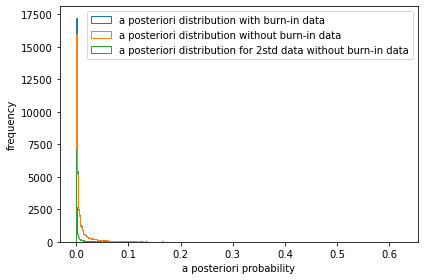

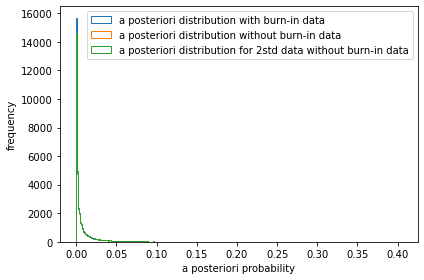

In [39]:
plot_posterior_distr2(sigma_array)

plot_posterior_distr2(sigma_array2)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 5368.9118439] [loc=0.013 scale=0.030]
[distfit] >[expon     ] [0.00 sec] [RSS: 1228.6802963] [loc=0.000 scale=0.013]
[distfit] >[pareto    ] [1.10 sec] [RSS: 115.9417618] [loc=-0.014 scale=0.014]
[distfit] >[dweibull  ] [1.51 sec] [RSS: 3886.5472766] [loc=0.000 scale=0.006]
[distfit] >[t         ] [0.60 sec] [RSS: 2725.0976522] [loc=0.001 scale=0.001]
[distfit] >[genextreme] [1.28 sec] [RSS: 394.7485403] [loc=0.001 scale=0.002]
[distfit] >[gamma     ] [1.23 sec] [RSS: 4702.0264583] [loc=0.000 scale=1.208]
[distfit] >[lognorm   ] [1.13 sec] [RSS: 1887.4476425] [loc=-0.000 scale=0.002]
[distfit] >[beta      ] [2.44 sec] [RSS: 80.1373672] [loc=0.000 scale=38384.556]
[distfit] >[uniform   ] [0.00 sec] [RSS: 7125.7996236] [loc=0.000 scale=0.405]
[distfit] >[loggamma  ] [1.06 sec] [RSS: 5466.9149971] [loc=-13.182 scale=1.671]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nbeta\na=0.78, b=6486009.49, loc=0.00, scale=38384.56'}, xlabel='Values', ylabel='Frequency'>)

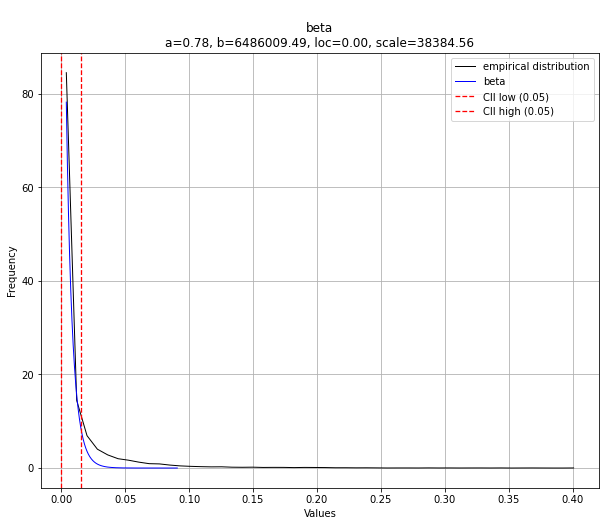

In [40]:
#try to find best pdf to fit our histogram
from distfit import distfit

# Initialize distfit
dist = distfit()

# Determine best-fitting probability distribution for data
dist.fit_transform(sigma_array2[burnin:])

# Print summary of evaluated distributions
#print(dist.summary)

#print(dist.model)

#Generate new samples out of fitted distribution
#Xgenerate = dist.generate(n=1000)
#print(Xgenerate)

# Plot results
dist.plot()
#plt.savefig("something.png")

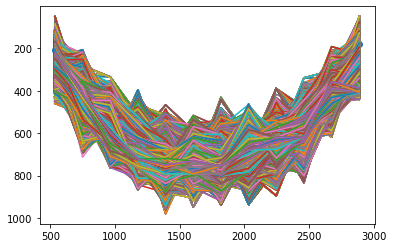

In [41]:
#Plot all models(the ones at least 2std's away from the mean) along-side the scattered m0 (starting model)
plt.plot(xj,post_m)
plt.scatter(xj,m01)   #height
plt.gca().invert_yaxis()

plt.show()

In [42]:
#task 8
# histograms of the change of height in each block of ice
def model_change_histogram(m):
    h_max = np.max(m)
    h_min = np.min(m)
    n_bins = 100
    bins_h = np.linspace(h_min,h_max,n_bins)
    M=len(m)
    fig, ax = plt.subplots(2,int(M/2),tight_layout=True,figsize=(10,5))
    fig.suptitle('X-axis equal for better comparison')
    for i in range(int(M/2)):
        ax[0,i].hist(m[i,:],bins=bins_h)
        ax[0,i].set_xlabel(f'Ice Block $h_{i+1}$[m]')
        ax[0,i].set_title(f'Ice Block {i+1}')
    ax[0,0].set_ylabel('Count')

    for i in range(int(M/2)):
        ax[1,i].hist(m[int(M/2)+i,:],bins=bins_h)
        ax[1,i].set_xlabel(f'Ice Block $h_{i+int(M/2+1)}$[m]')
        ax[1,i].set_title(f'Ice Block {i+int(M/2+1)}')
    ax[1,0].set_ylabel('Count')
    plt.show()

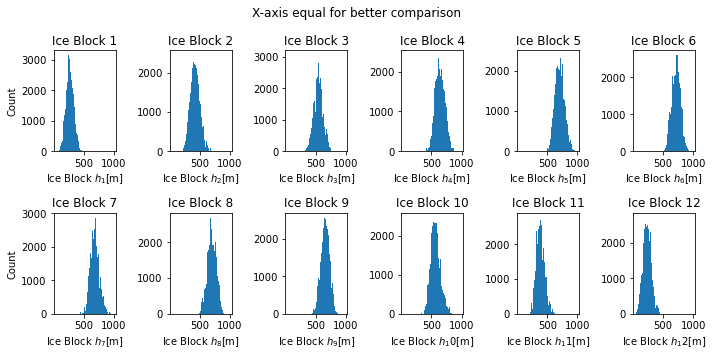

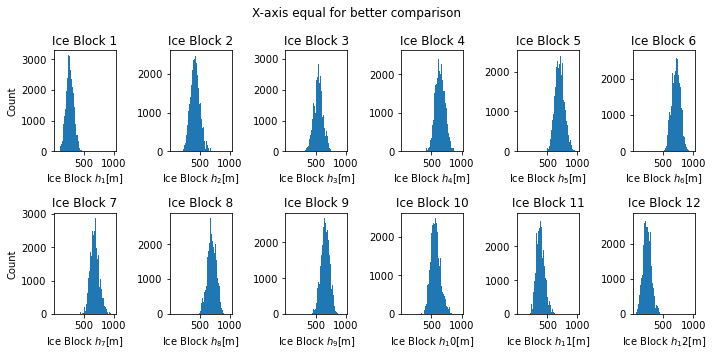

In [43]:
# using the models whose sigma are 2std's away from the mean
model_change_histogram(post_m)

model_change_histogram(post_m2)

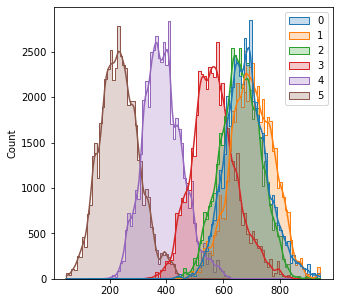

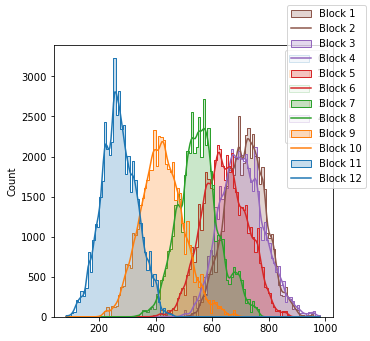

In [44]:
hlayers=[m[0,burnin:],m[1,burnin:],m[2,burnin:],m[3,burnin:],m[4,burnin:],m[5,burnin:],m[6,burnin:],m[7,burnin:],m[8,burnin:],m[9,burnin:],m[10,burnin:],m[11,burnin:]]
handles=['Block 1','Block 2','Block 3','Block 4','Block 5','Block 6','Block 7','Block 8','Block 9','Block 10','Block 11','Block 12']

ax,fig=plt.subplots(figsize=(5,5))

sns.histplot(hlayers[6:],element='step',kde=True)
ax.show()
ax,fig=plt.subplots(figsize=(5,5))

sns.histplot(hlayers[:6],element='step',kde=True)

ax.legend(handles)
ax.show()

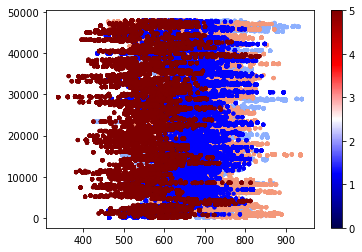

In [45]:
#scatter plot of neighboring blocks of ice

#blocks of ice at the middle of the valley have a kinda horizontal bottom, so share values, so correltaion in models
#blocks of ice at the edgese of the valley have a steep descending bottom, so dont share values, so no correlation in models

jet=plt.get_cmap('coolwarm')
jet2=plt.get_cmap('seismic')
color1=an_array = np.full((1, len(m[0,burnin:])), 1)
color3=an_array = np.full((1, len(m[0,burnin:])), 3)
color5=an_array = np.full((1, len(m[0,burnin:])), 5)

xx=np.linspace(0,len(m[6,burnin:]),len(m[6,burnin:]))
plt.scatter(m[6,burnin:],xx, s=10, c=color1, cmap=jet, vmin=0, vmax=4)
plt.scatter(m[7,burnin:],xx, s=10, c=color3, cmap=jet, vmin=0, vmax=4)
plt.scatter(m[8,burnin:],xx, s=10, c=color1, cmap=jet2, vmin=0, vmax=4)
plt.scatter(m[9,burnin:],xx, s=10, c=color5, cmap=jet2, vmin=0, vmax=4)
#plt.scatter(m[10,burnin:],xx, s=10, c=color5, cmap=jet2, vmin=0, vmax=4)
#plt.scatter(m[11,burnin:],xx, s=10, c=color5, cmap=jet, vmin=0, vmax=4)

plt.clim(0,5)
plt.colorbar()
plt.show()

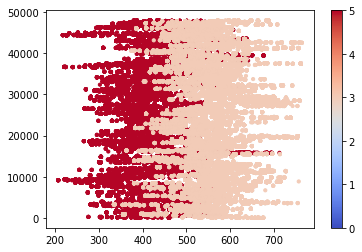

In [46]:
#scatter plot of two neighboring blocks of ice at small heights->steep->different heights
jet=plt.get_cmap('coolwarm')
color4=an_array = np.full((1, len(m[0,burnin:])), 5)
color6=an_array = np.full((1, len(m[0,burnin:])), 3)
xx=np.linspace(0,len(m[6,burnin:]),len(m[6,burnin:]))
plt.scatter(m[1,burnin:],xx, s=10, c=color4, cmap=jet, vmin=0, vmax=4)
plt.scatter(m[2,burnin:],xx, s=10, c=color6, cmap=jet, vmin=0, vmax=4)

plt.clim(0,5)
plt.colorbar()
plt.show()

<AxesSubplot:ylabel='Count'>

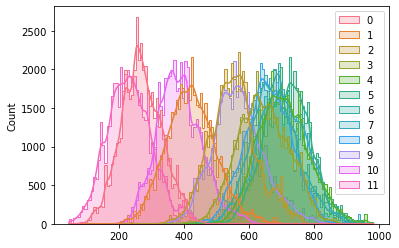

In [47]:
#hist of all blocks of ice models, be aware that the ones which appear to collerate at small heights(~200-600)
#are because there are the blocks from left and right part of the valley
brn=burnin
hlayers=[m[0,brn:],m[1,brn:],m[2,brn:],m[3,brn:],m[4,brn:],m[5,brn:],m[6,brn:],m[7,brn:],m[8,brn:],m[9,brn:],m[10,brn:],m[11,brn:]]
sns.histplot(hlayers,element='step',kde=True)

#Task 10
<br>
what I thought we could do:
<br>
do simpsons on each sigma, find their norm const
<br>
then do simpsons on the eq from task 10

In [48]:
#Normalization constant calculation 2nd way
def func2(dg,x,xj,m,m0):
    m1=m[:,int(x-1)]
    d_est=find_d_est(m1,xj+.0001)
    L = likelihood(dg,d_est)
    p=ppd(m1,m0)
    sigma=p*L
    #print(x)
    return sigma

norm_const_sigma=simpson38(func2,m01,dg1,m,xj,0, len(m[0,:]), sub_interval)
norm_const_sigma2=simpson38(func2,m02,dg2,m2,x2,0, len(m2[0,:]), sub_interval) #is this sub_interval the k steps???????????
print(1/norm_const_sigma)
print(1/norm_const_sigma2)
normalized_sigma=sigma_array/norm_const_sigma
normalized_sigma2=sigma_array2/norm_const_sigma2

TypeError: simpson38() takes 6 positional arguments but 8 were given

In [ ]:
#same as above but for less models.2
def func3(sigma,x,xj,m,sigma2):
#     print(int(x-1))
#     print(normalized_sigma[int(x-1)])
     return normalized_sigma[int(x-1)]*np.log2((normalized_sigma[int(x-1)])/(normalized_sigma2[int(x-1)]))

D=simpson38(func3,normalized_sigma,normalized_sigma2,m,xj,0, len(m[0,:]), sub_interval)
print("D",round(D,0))


In [ ]:
kk=np.zeros(10000)
for i in range(10000):
    kk[i]=np.log2(normalized_sigma[i]/normalized_sigma2[i])
sum(kk/10000)

In [ ]:
kk=np.zeros(10000)
for i in range(10000):
    kk[i]=normalized_sigma[i]*np.log2(normalized_sigma[i]/normalized_sigma2[i])
sum(kk)

In [ ]:
maximm=np.zeros(int(len(post_m)))
minimm=np.zeros(int(len(post_m)))

for i in range(int(len(post_m))):
    maximm[i]=np.max(post_m[i,:])
    minimm[i]=np.min(post_m[i,:])
#print(maximm,"\n",minimm)
width=maximm-minimm
#print(width)
volume=np.prod(width)
print(volume)

normal_constant=(1/(volume*int(len(sigma_array[burnin:]))))*(np.sum(1/sigma_array[burnin:]))
print(normal_constant)
normal_sigma_array=normal_constant*sigma_array[burnin:]


In [ ]:
maximm2=np.zeros(int(len(post_m2)))
minimm2=np.zeros(int(len(post_m2)))

for i in range(int(len(post_m2))):
    maximm2[i]=np.max(post_m2[i,:])
    minimm2[i]=np.min(post_m2[i,:])
#print(maximm2,"\n",minimm2)
width2=maximm2-minimm2
#print(width2)
volume2=np.prod(width2)
print(volume2)

normal_constant2=(1/(volume2*int(len(sigma_array2[burnin:]))))*(np.sum(1/sigma_array2[burnin:]))
print(normal_constant2)
normal_sigma_array2=normal_constant2*sigma_array2[burnin:]
#sigma_array2*normal_constant2

In [ ]:
normal_constant/normal_constant2

In [ ]:
( 1/len(normal_sigma_array) )* np.sum( np.log2 (normal_sigma_array/normal_sigma_array2 ) )



In [ ]:
np.sum( np.log2 (normal_sigma_array/normal_sigma_array2 ) )


In [ ]:
np.log2(normal_constant/normal_constant2) + ( 1/len(sigma_array) )* np.sum( np.log2 (sigma_array/sigma_array2 ) )


In [ ]:
vol=2
pst=3
b=1/(1/vol * (1/pst)) #= V* posterior
print(b)
#constant[i+1] = 1/(1/sum(mat*dw) * (1/Posterior[i+1]))